### Implementamos nuestra propia versión de U-NET inspirada en las ideas del paper de UNET

### Vamos a entrenar la red U-net para segmentar personas en imágenes o vídeos. Para ello vamos a usar las anotaciones de segmentación del dataset de coco. En una primera parte, construimos la máscara de segmentación para la clase persona usando el dataset de coco. Con la máscara construida y la imagen segmentada (máscara) obtenemos los datos para entrenar la red U-net desde cero. Se conseguirá segmentar personas de manera efectiva.

#### Importamos las bibliotecas necesarias

In [1]:
import tensorflow as tf
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, Accuracy

# Importamos algunas dependencias fundamentales de la API de tensorflow
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Conv2DTranspose, Flatten, BatchNormalization, Dropout,concatenate, LeakyReLU
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from plot_keras_history import plot_history


from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import Callback, ModelCheckpoint


2025-05-10 21:41:16.292145: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Implementamos una arquitectura muy similar a la de U-net

In [2]:
numero_filtros=64

def unet(dimension_tensor_entrada=(128, 128, 3),num_filtros=64):
    
    entrada = Input(dimension_tensor_entrada)

    # Parte de codificación del modelo 
    c1 = Conv2D(num_filtros, (3, 3), activation='relu', padding='same')(entrada)
    c1 = Conv2D(num_filtros, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(2*num_filtros, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(2*num_filtros, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(4*num_filtros, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(4*num_filtros, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(8*num_filtros, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(8*num_filtros, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(16*num_filtros, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(16*num_filtros, (3, 3), activation='relu', padding='same')(c5)

    # Parte de la Decodificación
    u6 = Conv2DTranspose(8*num_filtros, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(8*num_filtros, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(8*num_filtros, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(4*num_filtros, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(4*num_filtros, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(4*num_filtros, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(2*num_filtros, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(2*num_filtros, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(2*num_filtros, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(num_filtros, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(num_filtros, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(num_filtros, (3, 3), activation='relu', padding='same')(c9)

    salida = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[entrada], outputs=[salida])
    return model

#Se puede observar que el modelo U-net es completamente convolucional


#### Instanciamos el modelo U-net y mostramos su arquitectura

In [3]:
# Creamos un modelo U-Net
modelo = unet(dimension_tensor_entrada=(224, 224, 3),num_filtros=numero_filtros)

# Mostramos la arquitectura del modelo
modelo.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

2025-05-10 21:41:23.536291: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-05-10 21:41:23.536310: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: roger-ROG-Strix-G814JI-G814JI
2025-05-10 21:41:23.536312: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: roger-ROG-Strix-G814JI-G814JI
2025-05-10 21:41:23.536399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.230.2
2025-05-10 21:41:23.536408: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.183.1
2025-05-10 21:41:23.536410: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 535.183.1 does not match DSO version 535.230.2 -- cannot find working devices in this configuration
2025-05-10 21:41:23.536538: I tensorflow/core/plat

#### Definimos las funciones de error IoU y dice coefficient (suelen ser mejores indicadores de la calidad del modelo)

In [4]:
def iou(mascara_real, mascara_predicha, epsilon=1e-6):
    interseccion = tf.reduce_sum(mascara_real * mascara_predicha, axis=[1, 2, 3])
    union = tf.reduce_sum(mascara_real + mascara_predicha, axis=[1, 2, 3]) - interseccion
    iou = interseccion / (union + epsilon)
    return tf.reduce_mean(iou)

def coeficiente_dice(mascara_real, mascara_predicha, epsilon=1e-6):
    interseccion = tf.reduce_sum(mascara_real * mascara_predicha, axis=[1, 2, 3])
    dice = (2. * interseccion) / (tf.reduce_sum(mascara_real, axis=[1, 2, 3]) + tf.reduce_sum(mascara_predicha, axis=[1, 2, 3]) + epsilon)
    return tf.reduce_mean(dice)

#### Compilamos el modelo

###### Definimos tasa de aprendizaje y el optimizador que usamos (Adam)

In [5]:
tasa_aprendizaje = 0.0001 
optimizador =  Adam(learning_rate = tasa_aprendizaje)

##### Compilamos el modelo

In [6]:
# Compilamos el modelo
modelo.compile(optimizer=optimizador, loss='binary_crossentropy', metrics=['accuracy',iou,coeficiente_dice])

#### Definimos los datasets de entrenamiento y validacion

###### Empezamos definiendo las rutas a las distintas carpetas que almacenan las imágenes y las máscaras

In [7]:
ruta_actual = os.getcwd()
ruta_entrenamiento_imagenes = os.path.join(ruta_actual,"entrenamiento","imagenes")
ruta_entrenamiento_mascaras = os.path.join(ruta_actual,"entrenamiento","mascaras")
ruta_validacion_imagenes = os.path.join(ruta_actual,"validacion","imagenes")
ruta_validacion_mascaras = os.path.join(ruta_actual,"validacion","mascaras")

In [8]:
ruta=os.path.join(ruta_entrenamiento_imagenes,"000000000872.jpg")
parts = tf.strings.split(ruta, os.path.sep)

print(parts[-1].numpy().decode('utf-8')[:-3])
print(parts[-2]=="imagenes")
print(parts[-3].numpy().decode('utf-8'))

000000000872.
tf.Tensor(True, shape=(), dtype=bool)
entrenamiento


###### Creamos los generadores para entrenamiento y test usando la api tf.data.Dataset

In [9]:
#Las imágenes tienen tamaños reales de 200 píxeles x 200 píxeles
alto = 224
ancho = 224

tamano_lote = 16  
#Vamos a probar primero con un tamaño de lote de 32. No hay suficiente memoria. Bajamos el tamaño de lote a 16
'''
#Definimos funciones para preprocesar las imágenes a partir de la ruta
def cargar_preprocesar_imagen2(ruta):
    parts = tf.strings.split(ruta, os.path.sep)
    nombre_imagen = parts[-1].numpy().decode('utf-8')[:-4]
    tipo = parts[-3].numpy().decode('utf-8')

    if tipo == "entrenamiento":
        ruta_mascara = os.path.join(ruta_entrenamiento_mascaras, nombre_imagen + "_mascara.jpg")
    else:
        ruta_mascara = os.path.join(ruta_validacion_mascaras,nombre_imagen + "_mascara.jpg")
    
    
    imagen = tf.io.read_file(ruta)
    imagen = tf.image.decode_jpeg(imagen, channels=3)
    imagen = tf.image.resize(imagen, [alto, ancho])
    imagen = imagen / 255.0  # Normalizar a [0, 1]

    mascara = tf.io.read_file(ruta_mascara)
    mascara = tf.image.decode_jpeg(mascara, channels=1)
    mascara = tf.image.resize(mascara, [alto, ancho])
    mascara = imagen / 255.0  # Normalizar a [0, 1]

    imagen.set_shape((alto, ancho, 3))
    mascara.set_shape((alto, ancho, 1))
    
    return imagen, mascara
'''

def cargar_preprocesar_imagen(ruta):
    # Dividimos la ruta en sus componentes
    parts = tf.strings.split(ruta, os.path.sep)
    
    # Obtenemos el nombre de la imagen sin la extensión
    nombre_imagen = tf.strings.substr(parts[-1], 0, tf.strings.length(parts[-1]) - 4)
    
    # Obtenemos el tipo (entrenamiento o validación) desde la ruta
    tipo = parts[-3]
    
    # Construimos la ruta de la máscara dependiendo del tipo
    if tipo == "entrenamiento":
        ruta_mascara = tf.strings.join([ruta_entrenamiento_mascaras, nombre_imagen + "_mascara.jpg"], separator=os.path.sep)
    else:
        ruta_mascara = tf.strings.join([ruta_validacion_mascaras, nombre_imagen + "_mascara.jpg"], separator=os.path.sep)
    
    # Cargar y preprocesar la imagen
    imagen = tf.io.read_file(ruta)
    imagen = tf.image.decode_jpeg(imagen, channels=3)
    imagen = tf.image.resize(imagen, [alto, ancho])
    imagen = imagen / 255.0  # Normalizar a [0, 1]

    # Cargar y preprocesar la máscara
    mascara = tf.io.read_file(ruta_mascara)
    mascara = tf.image.decode_jpeg(mascara, channels=1)
    mascara = mascara/255
    
    mascara = tf.image.resize(mascara, [alto, ancho], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # La máscara no se normaliza, ya que representa etiquetas de clase
    
    # Establecemos las formas para asegurarnos de que las dimensiones sean estáticas
    imagen.set_shape((alto, ancho, 3))
    mascara.set_shape((alto, ancho, 1))
    
    return imagen, mascara

######## DATASET ENTRENAMIENTO ############
# Cargamos las imágenes desde el directorio de entrenamiento. Las imágenes son preprocesadas y preparadas para entrenar la red.
dataset_entrenamiento = tf.data.Dataset.list_files(ruta_entrenamiento_imagenes + '/*.jpg')
dataset_entrenamiento = dataset_entrenamiento.map(cargar_preprocesar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
#No hemos definido una función para hacer data augmentation (En principio no haremos data augmentation)
#dataset_entrenamiento = dataset_entrenamiento.map(aumento_imagenes, num_parallel_calls=tf.data.AUTOTUNE)

#barajamos el dataset
dataset_entrenamiento = dataset_entrenamiento.shuffle(buffer_size=1000)
#Hacemos los lotes del dataset del tamaño especificado
dataset_entrenamiento = dataset_entrenamiento.batch(tamano_lote)
dataset_entrenamiento = dataset_entrenamiento.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_entrenamiento = dataset_entrenamiento.repeat()  # Añadir repeat() para que se itere sobre el dataset una vez que se acaben los bastches


######## DATASET VALIDACIÓN ############
# Cargamos las imágenes desde el directorio de validación. Las imágenes son preprocesadas y preparadas para validar la red.
dataset_validacion = tf.data.Dataset.list_files(ruta_validacion_imagenes + '/*.jpg')

#Preprocesamos las imágenes
dataset_validacion = dataset_validacion.map(cargar_preprocesar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
#No necesitamos barajar el dataset de validación
#dataset_validacion = dataset_validacion.shuffle(buffer_size=100)
#dataset_validacion = dataset_validacion.cache() #No se debe usar (nos quedamos sin ram) 

#Hacemos los lotes del dataset del tamaño especificado
dataset_validacion = dataset_validacion.batch(tamano_lote)
dataset_validacion = dataset_validacion.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_validacion = dataset_validacion.repeat()



######## IMÁGENES DE CADA CONJUNTO ############
# Número de imágenes en el conjunto de entrenamiento, validación Y test
numero_imagenes_entrenamiento = len(os.listdir(ruta_entrenamiento_imagenes))
numero_imagenes_validacion = len(os.listdir(ruta_validacion_imagenes))


In [10]:
print(f"Número de imágenes para entrenamiento: {numero_imagenes_entrenamiento}")
print(f"Número de imágenes para validación: {numero_imagenes_validacion}")

Número de imágenes para entrenamiento: 64115
Número de imágenes para validación: 2693


#### Calculamos los pasos de entrenamiento y de validación del modelo

In [11]:
if numero_imagenes_entrenamiento % tamano_lote == 0:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote
else:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote +1

if numero_imagenes_validacion % tamano_lote == 0:
    pasos_validacion = numero_imagenes_validacion // tamano_lote
else:
    pasos_validacion = numero_imagenes_validacion // tamano_lote +1



print(f"Número de pasos de entrenamiento para un batch size de {tamano_lote}: {pasos_entrenamiento}")
print(f"Número de pasos de validación para un batch size de {tamano_lote}: {pasos_validacion}")


Número de pasos de entrenamiento para un batch size de 16: 4008
Número de pasos de validación para un batch size de 16: 169


#### Implementamos early stopping para el modelo

In [12]:

#parada_temprana = EarlyStopping(monitor='val_loss', 
#                               patience=15, 
#                               restore_best_weights=True)


class EarlyStoppingByIoU(Callback):
    def __init__(self, paciencia=0, verbose=0):
        super(EarlyStoppingByIoU, self).__init__()
        self.paciencia = paciencia
        self.verbose = verbose
        self.mejor_iou = -np.Inf
        self.espera = 0

    def on_epoch_end(self, epoca, logs=None):
        logs = logs or {}
        iou_actual = logs.get('val_iou') 

        if iou_actual is None:
            print("La métrica iou no está disponible en validación.")
            return

        if iou_actual > self.mejor_iou:
            self.mejor_iou = iou_actual
            self.espera = 0
        else:
            self.espera += 1
            if self.espera >= self.paciencia:
                self.model.stop_training = True
                if self.verbose > 0:
                    print(f'\nEpoca {epoca + 1}: Parada temprana basada en IoU')



#### Implementamos Checkpoint

In [13]:
parada_temprana = EarlyStoppingByIoU(paciencia=10, verbose=1)
checkpoint = ModelCheckpoint(
    f'mejor_modelo_{numero_filtros}.h5',
    monitor='val_iou',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_weights_only=False 
)


##### Definimos la caida del learning rate si el val_iou no aumenta tras 5 épocas

In [14]:
# Reduce Learning rate on Plateau
reducir_lr = ReduceLROnPlateau(monitor='val_iou', factor=0.1, patience=5, mode='max', min_lr=1e-6)


In [15]:
dataset = dataset_entrenamiento.as_numpy_iterator()

siguiente =dataset.next()

lote_imagenes = siguiente[0]
lote_mascaras = siguiente[1]


In [16]:
print(lote_mascaras[0].max())

1.0


#### Entrenamos el modelo

In [17]:
# Entrenamiento del modelo
numero_epocas = 200

historia = modelo.fit(
    dataset_entrenamiento,
    epochs=numero_epocas,
    validation_data=dataset_validacion,
    steps_per_epoch=pasos_entrenamiento,
    validation_steps=pasos_validacion,
    callbacks=[parada_temprana,reducir_lr,checkpoint]
)


Epoch 1/200


2024-08-26 01:03:47.038069: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2024-08-26 01:03:48.182721: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-08-26 01:03:48.182736: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-08-26 01:03:48.182774: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-08-26 01:03:51.126463: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-26 01:03:51.126491: W

4008/4008 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.8655 - iou: 0.2323 - coeficiente_dice: 0.3449
Epoch 1: val_iou improved from -inf to 0.32568, saving model to mejor_modelo_64.h5
4008/4008 [==============================] - 1515s 376ms/step - loss: 0.2927 - accuracy: 0.8655 - iou: 0.2323 - coeficiente_dice: 0.3449 - val_loss: 0.2362 - val_accuracy: 0.8895 - val_iou: 0.3257 - val_coeficiente_dice: 0.4484 - lr: 1.0000e-04
Epoch 2/200
4008/4008 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9026 - iou: 0.3509 - coeficiente_dice: 0.4746
Epoch 2: val_iou improved from 0.32568 to 0.38496, saving model to mejor_modelo_64.h5
4008/4008 [==============================] - 1503s 375ms/step - loss: 0.2097 - accuracy: 0.9026 - iou: 0.3509 - coeficiente_dice: 0.4746 - val_loss: 0.1957 - val_accuracy: 0.9080 - val_iou: 0.3850 - val_coeficiente_dice: 0.5077 - lr: 1.0000e-04
Epoch 3/200
4008/4008 [==============================] - ETA: 0s - loss: 

### Analizamos los resultado en historia

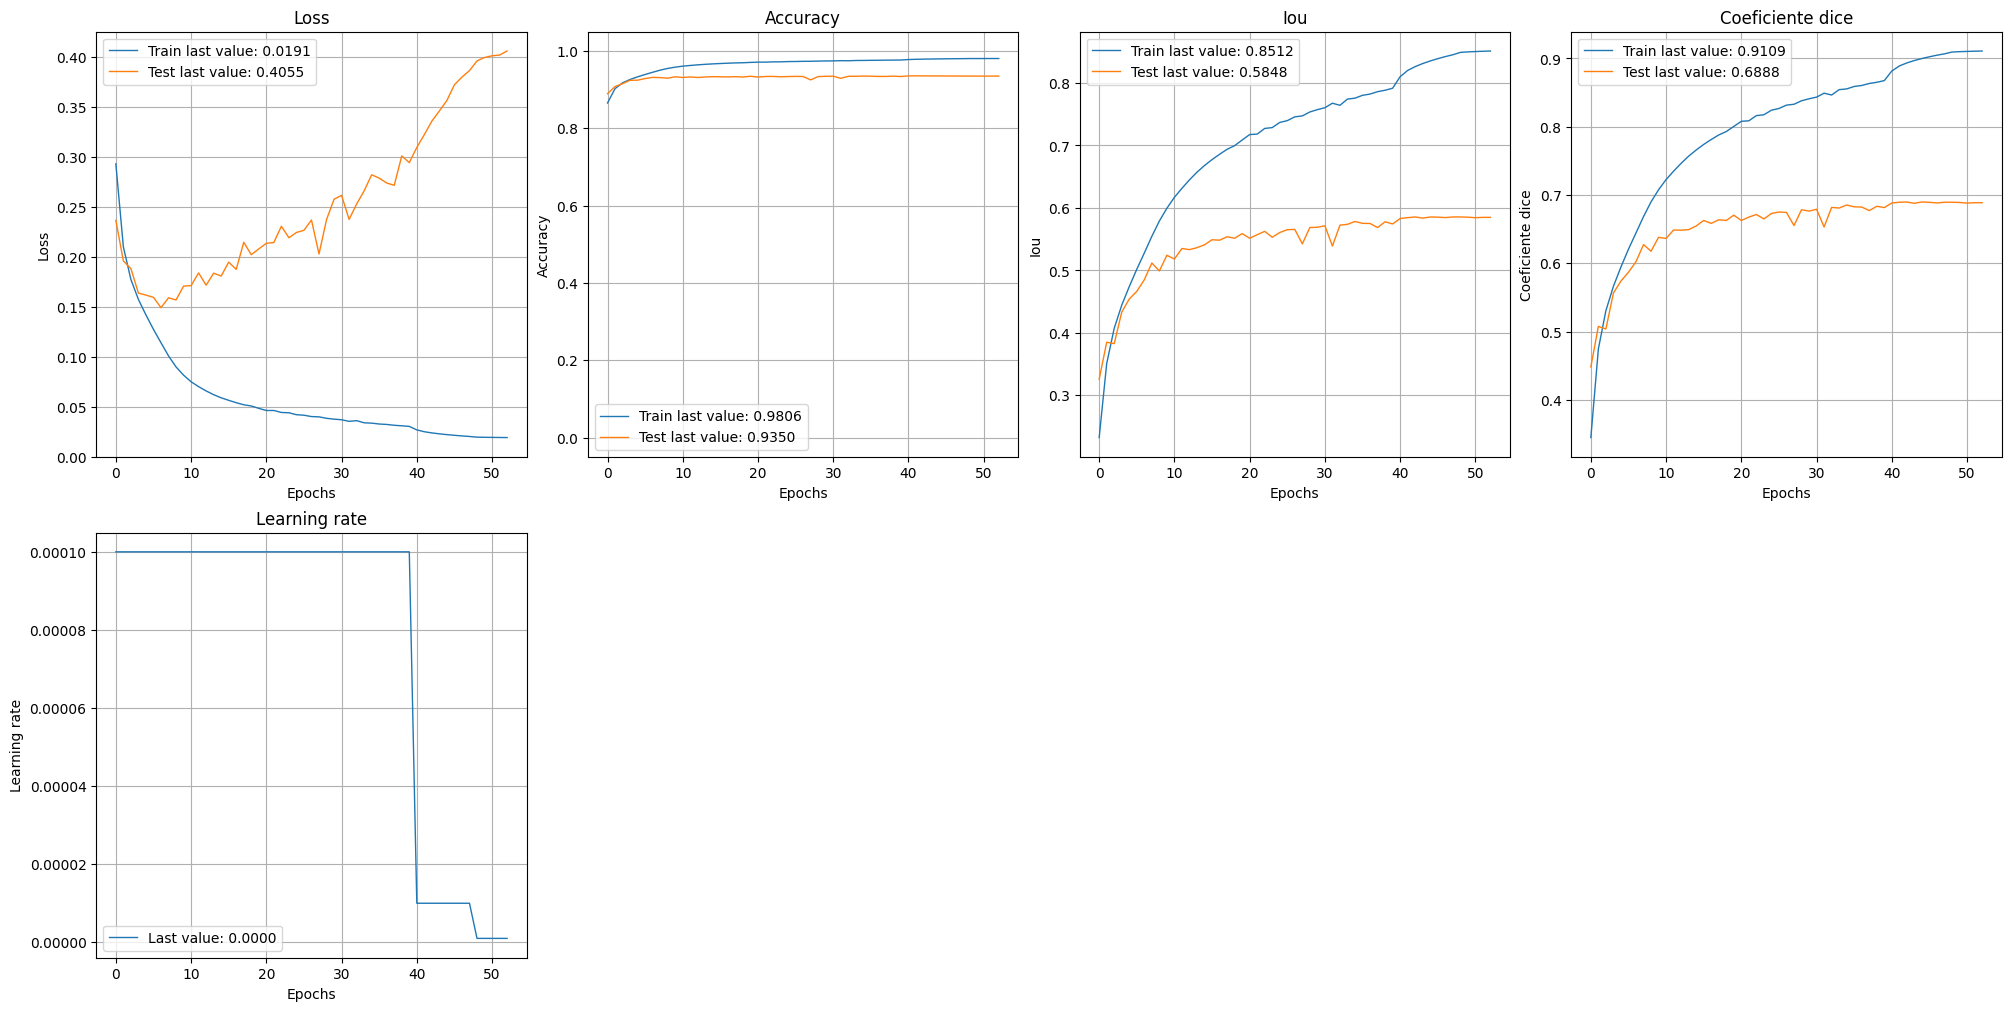

In [18]:
#Mostramos gráficas de interes del entrenamiento en función de las épocas

#from plot_keras_history import plot_history
plot_history(historia)
plt.show()

#### Guardamos los pesos de la red entrenada

In [19]:
# Esto no sería necesario porque los pesos del mejor modelo ya fueron guardados durante el entrenamiento
modelo.save(f"modelo_segmentacion_personas_{numero_filtros}.h5")

#### Podemos cargar los pesos del modelo

In [8]:
custom_objects = {
    'iou': iou,
    'coeficiente_dice': coeficiente_dice
}

modelo_cargado = load_model(f"mejor_modelo_{numero_filtros}.h5", custom_objects=custom_objects)

#### Cargamos una imagen y vemos los resultados del modelo

In [13]:
#ruta=os.path.join(ruta_validacion_imagenes,"000000006471.jpg")
ruta=os.path.join(ruta_validacion_imagenes,"000000004134.jpg")

imagen_prueba = cv2.imread(ruta)
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)
nuevo_ancho = 224
nuevo_alto = 224

# Redimensionar la imagen
imagen_redimensionada = cv2.resize(imagen_prueba, (nuevo_ancho, nuevo_alto))

imagen = tf.expand_dims(imagen_redimensionada,axis=0)

prediccion_mascara = modelo_cargado.predict(imagen)




1/1 [==============================] - 0s 124ms/step


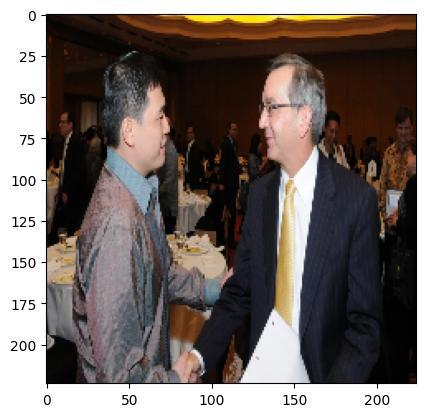

In [14]:
plt.imshow(imagen_redimensionada)

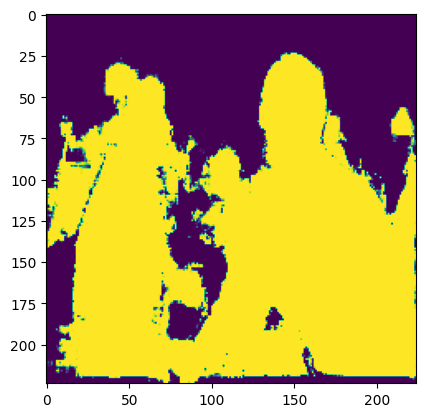

In [15]:
plt.imshow(prediccion_mascara.squeeze())

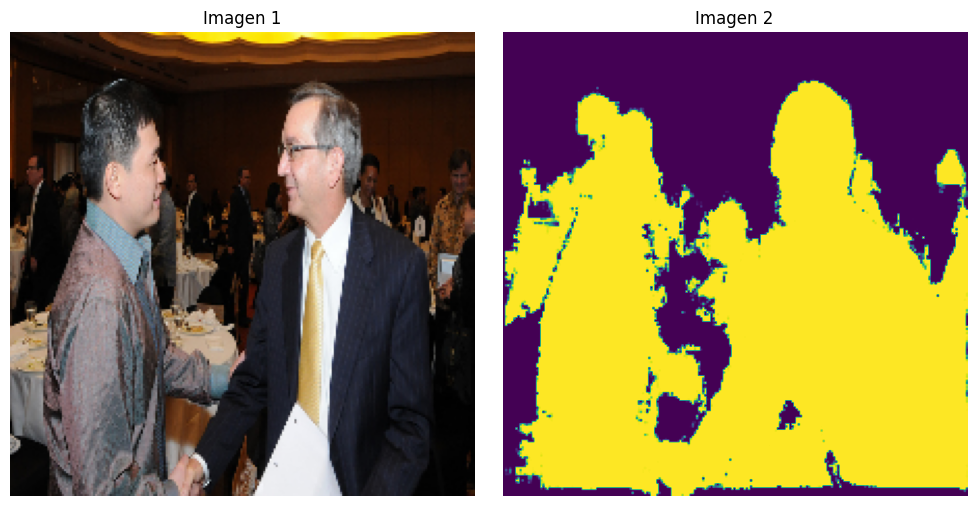

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # para cargar imágenes
import numpy as np  # si usas arrays



# Cargar dos imágenes (puedes usar np.random si solo estás probando)
#img1 = mpimg.imread('ruta/a/la/imagen1.jpg')
#img2 = mpimg.imread('ruta/a/la/imagen2.jpg')

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 fila, 2 columnas

# Mostrar cada imagen
axes[0].imshow(imagen_redimensionada)
axes[0].axis('off')  # Ocultar ejes si deseas
axes[0].set_title("Imagen 1")

axes[1].imshow(prediccion_mascara.squeeze())
axes[1].axis('off')
axes[1].set_title("Imagen 2")

# Ajustar espacio
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 129ms/step


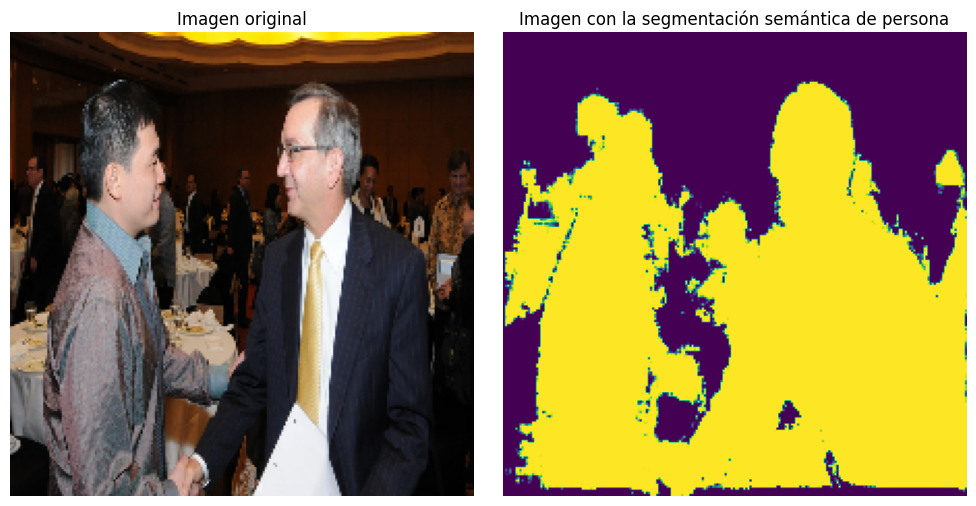

In [22]:
#ruta=os.path.join(ruta_validacion_imagenes,"000000006471.jpg")
ruta=os.path.join(ruta_validacion_imagenes,"000000004134.jpg")

imagen_prueba = cv2.imread(ruta)
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)
nuevo_ancho = 224
nuevo_alto = 224

# Redimensionar la imagen
imagen_redimensionada = cv2.resize(imagen_prueba, (nuevo_ancho, nuevo_alto))

imagen = tf.expand_dims(imagen_redimensionada,axis=0)

prediccion_mascara = modelo_cargado.predict(imagen)



# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 fila, 2 columnas

# Mostrar cada imagen
axes[0].imshow(imagen_redimensionada)
axes[0].axis('off')  # Ocultar ejes si deseas
axes[0].set_title("Imagen original")

axes[1].imshow(prediccion_mascara.squeeze())
axes[1].axis('off')
axes[1].set_title("Imagen con la segmentación semántica de persona")

# Ajustar espacio
plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 125ms/step


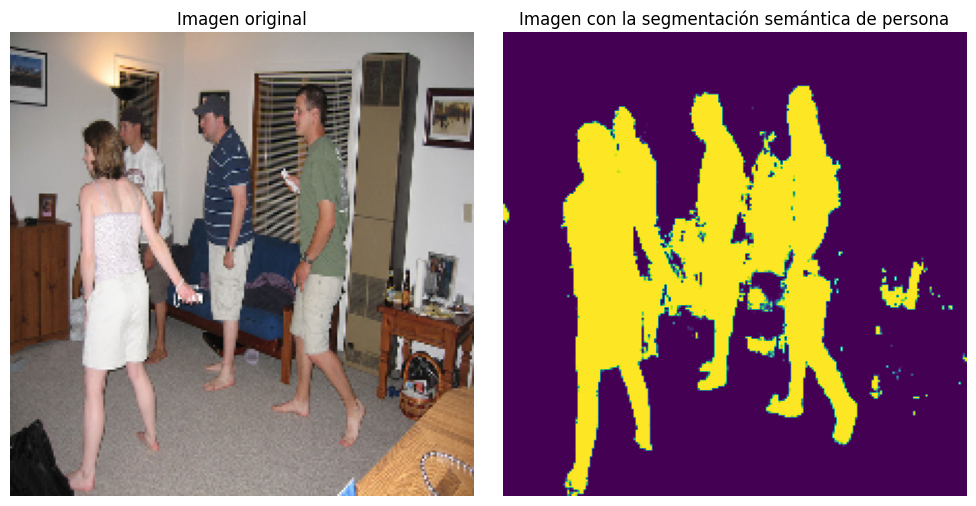

In [23]:
#ruta=os.path.join(ruta_validacion_imagenes,"000000006471.jpg")
ruta=os.path.join(ruta_validacion_imagenes,"000000013729.jpg")

imagen_prueba = cv2.imread(ruta)
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)
nuevo_ancho = 224
nuevo_alto = 224

# Redimensionar la imagen
imagen_redimensionada = cv2.resize(imagen_prueba, (nuevo_ancho, nuevo_alto))

imagen = tf.expand_dims(imagen_redimensionada,axis=0)

prediccion_mascara = modelo_cargado.predict(imagen)



# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 fila, 2 columnas

# Mostrar cada imagen
axes[0].imshow(imagen_redimensionada)
axes[0].axis('off')  # Ocultar ejes si deseas
axes[0].set_title("Imagen original")

axes[1].imshow(prediccion_mascara.squeeze())
axes[1].axis('off')
axes[1].set_title("Imagen con la segmentación semántica de persona")

# Ajustar espacio
plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 117ms/step


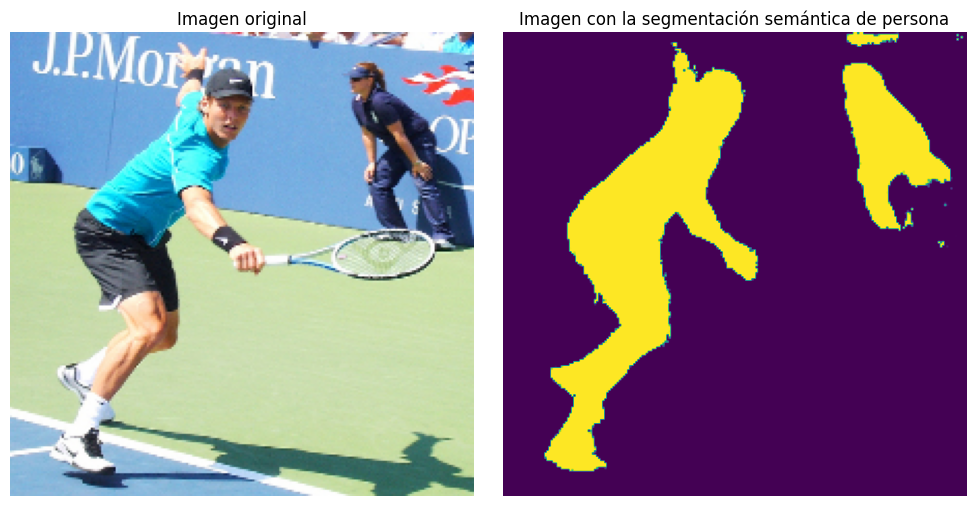

In [24]:
#ruta=os.path.join(ruta_validacion_imagenes,"000000006471.jpg")
ruta=os.path.join(ruta_validacion_imagenes,"000000119995.jpg")

imagen_prueba = cv2.imread(ruta)
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)
nuevo_ancho = 224
nuevo_alto = 224

# Redimensionar la imagen
imagen_redimensionada = cv2.resize(imagen_prueba, (nuevo_ancho, nuevo_alto))

imagen = tf.expand_dims(imagen_redimensionada,axis=0)

prediccion_mascara = modelo_cargado.predict(imagen)



# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 fila, 2 columnas

# Mostrar cada imagen
axes[0].imshow(imagen_redimensionada)
axes[0].axis('off')  # Ocultar ejes si deseas
axes[0].set_title("Imagen original")

axes[1].imshow(prediccion_mascara.squeeze())
axes[1].axis('off')
axes[1].set_title("Imagen con la segmentación semántica de persona")

# Ajustar espacio
plt.tight_layout()
plt.show()

